## Một cách tiếp cận tính toán áp dụng Simulated Annealing để nghiên cứu tính ổn định của mạng tương tác protein trong ung thư và rối loạn thần kinh. 

Authors: NhanTV, Trung NT <br>
Master Student<br>
VNU - HUS


## Mục đích

Dựng lại bài báo khoa học: "A computational approach inspired by simulated annealing to study the stability of protein interaction networks in cancer and neurological disorders". 

## 1 Lọc PPI

### 1.1 Nhập thư viện

In [2]:
import numpy as np
import pandas as pd
import glob
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2 Đọc dữ liệu PPI, uniprot

PPI.csv (protein- protein interation): gồm hai cột, mỗi cột là một dãy các protein người ở dạng ID, mỗi dòng là các tương tác giữa các protein với nhau. <br>
uniprot-brca1-filtered-organism__Homo+sapiens+(Human)+[9606]_.csv: cột Entry chứa ID của protein, cột Gene names chứa tên của gen tương ứng với protein đó.

In [88]:
ppi = pd.read_csv("D:/Data Science/Data Science Core/Documents/Data Mining/Data/PPI.csv")
ppi.head()

,GeneA,GeneB
0,A0AV47,A0AV47
1,A0FGR8,A0FGR9
2,A5PKW4,A5PKW4
3,A8K0Z3,B3KMC4
4,A8MVA2,B0QYK1


In [82]:
uniprot = pd.read_csv("D:/Data Science/Data Science Core/Documents/Data Mining/Project/uniprot-filtered-organism__Homo+sapiens+(Human)+(9606)_+AND+review--.csv")
uniprot.head()

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length
0,Q96IY4,CBPB2_HUMAN,reviewed,Carboxypeptidase B2 (EC 3.4.17.20) (Carboxypep...,CPB2,Homo sapiens (Human),423
1,P22362,CCL1_HUMAN,reviewed,C-C motif chemokine 1 (Small-inducible cytokin...,CCL1 SCYA1,Homo sapiens (Human),96
2,Q8NCR9,CLRN3_HUMAN,reviewed,Clarin-3 (Transmembrane protein 12) (Usher syn...,CLRN3 TMEM12 USH3AL1,Homo sapiens (Human),226
3,Q8IUK8,CBLN2_HUMAN,reviewed,Cerebellin-2,CBLN2 UNQ1892/PRO4338,Homo sapiens (Human),224
4,Q9BX69,CARD6_HUMAN,reviewed,Caspase recruitment domain-containing protein 6,CARD6,Homo sapiens (Human),1037


### 1.3 Lọc PPI

Số lượng tương tác giữa các protein

In [80]:
ppi.shape[0]

166776

#### 1.3.1 Lọc bỏ các tương tác giữa protein với chính nó.

In [92]:
ppi_self_drop = ppi[ppi["GeneA"] != ppi["GeneB"]]
ppi_self_drop.shape[0]

165797

In [145]:
ppi_self_drop.head()

,GeneA,GeneB
1,A0FGR8,A0FGR9
3,A8K0Z3,B3KMC4
4,A8MVA2,B0QYK1
6,B0QYK1,C9JC66
7,B1GXI8,B4DV56


#### 1.3.2 Kiểm tra sự dư thừa dữ liệu

Ta cần kiểm tra xem có tồn tại các liên kết giống nhau hay không, các liên kết giống nhau trong dữ liệu PPI xuất hiện nếu với một dòng (GeneA, GeneB) tồn tại một dòng khác (GeneB, GeneA).

In [146]:
# Tạo một DataFrame mới bằng cách đảo hai cột của ppi_self_drop cho nhau
ppi_inverse = pd.DataFrame({"GeneA":ppi_self_drop["GeneB"], "GeneB":ppi_self_drop["GeneA"]})
ppi_inverse.head()

,GeneA,GeneB
1,A0FGR9,A0FGR8
3,B3KMC4,A8K0Z3
4,B0QYK1,A8MVA2
6,C9JC66,B0QYK1
7,B4DV56,B1GXI8


In [148]:
# Nối hai DataFrame ppi_self_drop với ppi_inverse 
ppi_concat = pd.concat([ppi_self_drop, ppi_inverse])
ppi_concat.shape[0]

331594

In [152]:
# Chọn các hàng giống nhau
duplicate_RowsDF = ppi_concat[ppi_concat.duplicated()]
 
print("Các hàng giống nhau là:")
print(duplicate_RowsDF)

Các hàng giống nhau là:
Empty DataFrame
Columns: [GeneA, GeneB]
Index: []


Như vậy không tồn tại các liên kết dư thừa trong dữ liệu ppi_self_drop.

#### 1.3.3 Lọc các protein không có trong uniprot

Lọc bỏ các tương tác protein mà các protein không có trong "uniprot-brca1-filtered-organism__Homo+sapiens+(Human)+[9606]_.csv"

In [160]:
# Các protein id trong từng cột GeneA và GeneB của ppi_self_drop
Gene_A = np.unique(ppi_self_drop["GeneA"])
Gene_B = np.unique(ppi_self_drop["GeneB"])
print(Gene_A)
print(Gene_B)

['A0FGR8' 'A8K0Z3' 'A8MVA2' ... 'Q9Y6M7' 'Q9Y6Q9' 'Q9Y6X2']
['A0AUZ9' 'A0AV47' 'A0AV96' ... 'Q9ZPE7' 'Q9ZV85' 'Q9ZVX4']


In [172]:
# Các protein id trong dữ liệu ppi_self_drop
Gene_concat = np.concatenate((Gene_A, Gene_B))
ppi_id = np.unique(Gene_concat)
ppi_id

array(['A0AUZ9', 'A0AV47', 'A0AV96', ..., 'Q9ZPE7', 'Q9ZV85', 'Q9ZVX4'],
      dtype=object)

In [176]:
# Các protein id có trong uniprot
uniprot_id = uniprot["Entry"]
uniprot_id.head()

0    Q96IY4
1    P22362
2    Q8NCR9
3    Q8IUK8
4    Q9BX69
Name: Entry, dtype: object

In [184]:
# Các protein_id trong ppi_self_drop có trong uniprot
protein_id = list(set(ppi_id).intersection(uniprot_id))
len(protein_id)

15160

In [250]:
# Những vị trí trong cột GeneA của ppi_self_drop có trong protein_id
boolean_A = []
for x in ppi_self_drop["GeneA"]:
    boolean_A.append(x in protein_id)

In [224]:
# Những vị trí trong cột GeneB của ppi_self_drop có trong protein_id
boolean_B = []
for x in ppi_self_drop["GeneB"]:
    boolean_B.append(x in protein_id)

In [237]:
# Những vị trí ở cả hai cột GeneA và GeneB của ppio_self_drop đều có trong protein_id
boolean = []
for i in range(len(boolean_A)):
    if boolean_A[i] == True and boolean_B[i] == True:
        boolean.append(True)
    elif boolean_A[i] == True and boolean_B[i] == False:
        boolean.append(False)
    elif boolean_A[i] == False and boolean_B[i] == False:
        boolean.append(False)
    elif boolean_A[i] == False and boolean_B[i] == True:
        boolean.append(False)

Lọc các protein ở ppi_self_drop không có trong uniprot

In [241]:
ppi_filter = ppi_self_drop[boolean]

In [289]:
ppi_filter.to_csv ("D:/Data Science/Data Science Core/Documents/Data Mining/Project/ppi_filter.csv", index = None, header=True)

In [248]:
print("Dữ liệu PPI sau khi lọc có: %d protein và %d tương tác." %(len(protein_id),len(ppi_filter)))

Dữ liệu PPI sau khi lọc có: 15160 protein và 160320 tương tác.


### 1.4 Gán tên cho PPI

In [282]:
G_A = []
for x in ppi_filter["GeneA"]:
    G_A.append(uniprot["Gene names"][uniprot["Entry"] == x].to_list()[0])

In [284]:
G_B = []
for x in ppi_filter["GeneB"]:
    G_B.append(uniprot["Gene names"][uniprot["Entry"] == x].to_list()[0])

In [288]:
ppi_filtering = pd.DataFrame({"GeneA":G_A, "GeneB":G_B})
ppi_filtering.head()

,GeneA,GeneB
0,ESYT2 FAM62B KIAA1228,ESYT3 FAM62C
1,DNASE2 DNASE2A DNL2,OPA1 KIAA0567
2,DNASE2 DNASE2A DNL2,UBC
3,DNASE2 DNASE2A DNL2,RRM1 RR1
4,DNASE2 DNASE2A DNL2,XRN1 SEP1


In [290]:
ppi_filtering.to_csv ("D:/Data Science/Data Science Core/Documents/Data Mining/Project/ppi_filtering.csv", index = None, header=True)

## 2 Dữ liệu biểu hiện gen

### 2.1 Chuyển tên các gen trong PPI thành HUGO symbols

Tên gen được lấy từ Human Genome U133 Plus 2.0

In [26]:
# Chuyển các HUGO symbols sang tên gen
affyids = pd.read_csv("D:/Data Science/Data Science Core/Documents/Data Mining/Project/affyids.csv")
affyids.head()

,affy_hg_u133_plus_2,external_gene_name
0,236894_at,Y_RNA
1,219955_at,Y_RNA
2,1560901_at,RNU1-129P
3,243551_at,RNU1-122P
4,216856_s_at,AL109925.1


In [66]:
# Nhóm các HUGO symbols với cùng một tên gen với nhau
group = affyids.groupby("external_gene_name")
affy = group.agg(", ".join)

In [67]:
affy = affy.reset_index()
affy.head()

,external_gene_name,affy_hg_u133_plus_2
0,1-Dec,220781_at
1,1-Mar,"218865_at, 219574_at, 229383_at, 235385_at, 15..."
2,10-Mar,"230824_at, 237724_at"
3,11-Mar,239359_at
4,2-Mar,"221636_s_at, 227417_at, 219527_at, 210075_at"


In [77]:
# PPI sau khi lọc bỏ các tên gen cùng chỉ một gen
ppi_filtering_final = pd.read_csv("D:/Data Science/Data Science Core/Documents/Data Mining/Project/ppi_filtering_final.csv")
ppi_filtering_final.head()

,GeneA,GeneB
0,ESYT2,ESYT3
1,DNASE2,OPA1
2,DNASE2,UBC
3,DNASE2,RRM1
4,DNASE2,XRN1


In [88]:
# Ánh xạ tên các gen trong PPI sang HUGO symbols
GA = []
GB = []

for x, y in zip(ppi_filtering_final["GeneA"], ppi_filtering_final["GeneB"]):
    A = affy["affy_hg_u133_plus_2"][affy["external_gene_name"] == x].to_list()
    B = affy["affy_hg_u133_plus_2"][affy["external_gene_name"] == y].to_list()
    if A != [] and B != []:
        GA.append(A[0])
        GB.append(B[0])

In [102]:
PPIs = pd.DataFrame({"GeneA": GA, "GeneB": GB})

In [103]:
PPIs.head()

,GeneA,GeneB
0,"224699_s_at, 1558511_s_at, 1555830_s_at, 22469...","1554912_at, 239770_at, 1557793_at"
1,"209831_x_at, 214992_s_at","212213_x_at, 212214_at, 214306_at"
2,"209831_x_at, 214992_s_at","208980_s_at, 211296_x_at"
3,"209831_x_at, 214992_s_at","201476_s_at, 201477_s_at"
4,"209831_x_at, 214992_s_at","1555785_a_at, 225814_at, 233632_s_at, 1570394_at"


In [104]:
PPIs.to_csv ("D:/Data Science/Data Science Core/Documents/Data Mining/Project/PPIs.csv", index = None, header=True)

In [3]:
# Tên gen trong PPI đã được chuyển sang HUGO symbols và lọc bỏ một số tên ##
hugo_ppi = pd.read_csv("D:/Data Science/Data Science Core/Documents/Data Mining/Project/HUGO_PPI.csv")
hugo_ppi.head()

,GeneA,GeneB
0,224699_s_at,1554912_at
1,209831_x_at,212213_x_at
2,209831_x_at,208980_s_at
3,209831_x_at,201476_s_at
4,209831_x_at,1555785_a_at


### 2.2 Tính năng lượng cho mạng PPI 

In [4]:
"""Dữ liệu được lấy sau khi chạy trong R, dữ liệu bao gồm các trường: tên gen, z-score, s và barcode"""
path = "D:/Data Science/Data Science Core/Documents/Data Mining/Project/Kidney/C/R_result"
all_files = glob.glob(path + "/*.csv")
data = []
for filename in all_files:
    disease = pd.read_csv(filename, index_col=None, header=0)
    data.append(disease)

In [5]:
nE = []
for ex_gen in data:
    ex_gen.rename(columns={"Unnamed: 0": "GeneA"}, inplace = True)
    common_1 = pd.merge(hugo_ppi["GeneA"], ex_gen, on = "GeneA")
    ex_gen.rename(columns={"GeneA": "GeneB"}, inplace = True)
    common_2 = pd.merge(hugo_ppi["GeneB"], ex_gen, on = "GeneB")
    df = pd.DataFrame({"GeneA":common_1["GeneA"], "GeneB":common_2["GeneB"], "S_A":common_1["s"],"S_B":common_2["s"], "barcode_A":common_1["barcode"], "barcode_B":common_2["barcode"]})
    s = np.zeros((df.shape[0]))
    for i in range(df.shape[0]):
        if df.iloc[i, 4] == 1 and df.iloc[i, 5] == 1:
            s[i] = -(-1)*df.iloc[i, 2]*df.iloc[i, 3]
        else: 
            s[i] = -(1)*df.iloc[i, 2]*df.iloc[i, 3]
    nE.append(sum(s))
df_nE = pd.DataFrame({"nE": nE})
df_nE.to_csv ("D:/Data Science/Data Science Core/Documents/Data Mining/Project/Kidney/C/nE/nE_C.csv", index = None, header=True)

In [6]:
df.head()

,GeneA,GeneB,S_A,S_B,barcode_A,barcode_B
0,224699_s_at,1554912_at,0.994582,0.269644,0,0
1,209831_x_at,1554912_at,0.588783,0.269644,0,0
2,209831_x_at,212213_x_at,0.588783,1.000000,0,1
3,209831_x_at,212213_x_at,0.588783,1.000000,0,1
4,209831_x_at,212213_x_at,0.588783,1.000000,0,1


In [7]:
nE_D = pd.read_csv("D:/Data Science/Data Science Core/Documents/Data Mining/Project/Liver/D/nE/nE_D.csv")
nE_C = pd.read_csv("D:/Data Science/Data Science Core/Documents/Data Mining/Project/Liver/C/nE/nE_C.csv")

In [8]:
nE_D["State"] = "Disease"

In [9]:
nE_D.head()

,nE,State
0,-30553.967486,Disease
1,-36129.033660,Disease
2,-37396.346781,Disease
3,-36195.574174,Disease
4,-40954.734714,Disease


In [10]:
nE_C["State"] = "Control"

In [11]:
df_nE = pd.concat([nE_C, nE_D])

In [12]:
df_nE.head()

,nE,State
0,-50774.643343,Control
1,-45117.622592,Control
2,-48340.482797,Control
3,-46607.622200,Control
4,-43520.454168,Control


In [117]:
df_nE.to_csv ("D:/Data Science/Data Science Core/Documents/Data Mining/Project/Kidney/df_nE.csv", index = None, header=True)

In [13]:
Wil_rank = scipy.stats.wilcoxon(nE_C["nE"], nE_D["nE"])

In [14]:
Wil_rank

WilcoxonResult(statistic=183.0, pvalue=4.043098336586011e-14)

In [120]:
print (plt.style.available)
mpl.style.use(['ggplot'])

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


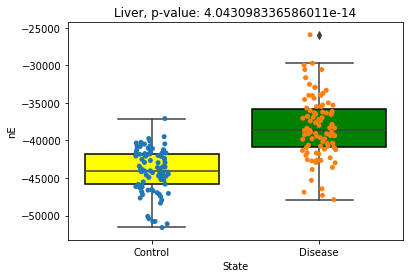

In [15]:
ax= sns.boxplot(x="State", y="nE", data=df_nE)
ax= sns.stripplot(x="State", y="nE", data=df_nE, jitter=True, edgecolor="gray")

boxtwo = ax.artists[0]
boxtwo.set_facecolor('yellow')
boxtwo.set_edgecolor('black')
boxthree=ax.artists[1]
boxthree.set_facecolor('green')
boxthree.set_edgecolor('black')

plt.title ('Liver, p-value: ' + str(Wil_rank[1]))
plt.ylabel ('nE')
plt.show()